# Delay discounting task


## 1. Initialization

### 1) Task: Delay discounting task

- **Design variables**
    - `t_ss` ($t_{SS}$): Delay for the SS (smaller, sooner) option
    - `t_ll` ($t_{LL}$): Delay for the LL (larger, later) option
        - The delay on SS option should be sooner than that of LL option ($t_{SS} < t_{LL}$).
    - `r_ss` ($R_{SS}$): Reward value for the SS (smaller, sooner) option
    - `r_ll` ($R_{LL}$): Reward value for the LL (larger, later) option
        - The reward on SS option should be smaller than that of LL option ($R_{SS} < R_{LL}$).
- **Possible responses**:
    - `choice`: `0` (SS option), `1` (LL option)

In [90]:
from adopy.tasks.dd import TaskDD
# from adopy.base._task import Task

task = TaskDD()

# 'Delay discounting task'
# task.name

# in IDM_model we have the same parameters but are named slightly different:
# ['time_null','time_reward','value_null','value_reward']
# ['t_ss','t_ll','r_ss','r_ll']
# task.designs

# ['choice']
# task.responses

### 2) Model: Hyperbolic model (Mazur, 1987)

$$
\begin{aligned}
    \text{discounting factor} \; D(t) &= \frac{1}{1 + kt} \\
    V_{SS} &= R_{SS} \cdot D(t_{SS}) \\
    V_{LL} &= R_{LL} \cdot D(t_{LL}) \\
    P(LL \, over \, SS) &= \frac{1}{1 + \exp [- \tau \cdot \gamma (V_{LL} - V_{SS})]}
\end{aligned}
$$

- **Model parameters**
    - `k` ($k$): discounting rate parameter
    - `tau` ($\tau$): inverse temperature

In [91]:
from adopy.tasks.dd import ModelHyp

# Several Models available
""" 
    'ModelExp',
    'ModelHyp',
    'ModelHPB',
    'ModelCOS',
    'ModelQH',
    'ModelDE',
"""

model = ModelHyp()

# 'Hyperbolic model for the DD task'
# model.name

# in IDM_model we have the same parameters but are named slightly different:
# ['kappa','gamma']
# ['k', 'tau']
# model.params


### 3) Grid definition

In [92]:
import numpy as np

### We will keep these grid definitions as they are. We will change after we figure out how this works ###

# in IDM_model we have the same parameters but are named slightly different:
# ['time_null','time_reward','value_null','value_reward']
# ['t_ss','t_ll','r_ss','r_ll']

grid_design = {
    # [Now]
    't_ss': [0],
    # [3 days, 5 days, 1 week, 2 weeks, 3 weeks,
    #  1 month, 6 weeks, 2 months, 10 weeks, 3 months,
    #  4 months, 5 months, 6 months, 1 year, 2 years,
    #  3 years, 5 years, 10 years] in a weekly unit
    't_ll': [0.43, 0.714, 1, 2, 3,
             4.3, 6.44, 8.6, 10.8, 12.9,
             17.2, 21.5, 26, 52, 104,
             156, 260, 520],
    # [$12.5, $25, ..., $775, $787.5]
    'r_ss': np.arange(12.5, 800, 12.5),
    # [$800]
    'r_ll': [800]
}

# in IDM_model we have the same parameters but are named slightly different:
# ['kappa','gamma']
# ['k','tau']

grid_param = {
    # 50 points on [10^-5, ..., 1] in a log scale
    'k': np.logspace(-5, 0, 50, base=10),
    # 10 points on (0, 5] in a linear scale
    'tau': np.linspace(0, 5, 11)[1:]
}

grid_response = {
    'choice': [0, 1]
}

### 4) Engine initialization

In [93]:
from adopy import Engine

engine = Engine(task, model, grid_design, grid_param, grid_response)

# Posterior means (k, tau)
# [k,tau] = [0.120679,1.879091]
# engine.post_mean

# Standard deviations for the posterior distribution (k, tau)
# [k,tau] = [0.210282,1.436140]
# engine.post_sd


## 2. Using ADO

### Initializing  parameters for simulation


In [108]:
# number of trials
N_TRIAL = 5

# 1 week, 2 weeks, 1 month, 6 months, 1 year, 2 years, 10 years
D_CAND = [1, 2, 4.3, 26, 52, 104, 520]

# DELTA_R_SS for the staircase method:
# The amount of changes on R_SS every 6 trials.
DELTA_R_SS = [400, 200, 100, 50, 25, 12.5]

# True parameter values to simulate responses
# after we get this to work, we can select from prior distribution
PARAM_TRUE = {'k': 0.12, 'tau': 1.5}

### Generate choice/response using the true parameters

In [95]:
from scipy.stats import bernoulli

def get_simulated_response(design):
    # Calculate the probability to choose a variable option
    t_ss, t_ll, r_ss, r_ll = (
        design['t_ss'], design['t_ll'],
        design['r_ss'], design['r_ll']
    )
    k, tau = PARAM_TRUE['k'], PARAM_TRUE['tau']
    
    u_ss = r_ss * (1. / (1 + k * t_ss))
    u_ll = r_ll * (1. / (1 + k * t_ll))
    p_obs = 1. / (1 + np.exp(-tau * (u_ll - u_ss)))

    # Randomly sample a binary choice response from Bernoulli distribution
    return bernoulli.rvs(p_obs)



In [123]:

def ask_for_response(design):
    response = input('Please choose: >>>(0) {} in {} days<<< OR >>>(1) {} in {} days<<<'.format(design['r_ss'],design['t_ss'],design['r_ll'],design['t_ll']))
    response = int(response)
    if response in [0,1]:
        pass
    else:
        print('ERROR, you selected {}, response needs to be 0 or 1'.format(response))
        print('Exiting now, try again')
        exit
    return response


### Simulation

In [124]:
import pandas as pd

# Make an empty DataFrame to store data
columns = ['trial', 'response', 'mean_k', 'mean_tau', 'sd_k', 'sd_tau','t_ss','t_ll','r_ss','r_ll']
df_simul = pd.DataFrame(None, columns=columns)

# Reset the engine as an initial state
engine.reset()

for i in range(N_TRIAL):
    # Design selection / optimization
    design = engine.get_design('optimal')
    # print(design)
    
    # Experiment
    response = ask_for_response(design)
    
    # Bayesian updating
    engine.update(design, response)

    # Save the information for updated posteriors
    dict_app = {
        'trial': i + 1,
        'response': response,
        'mean_k': engine.post_mean[0],
        'mean_tau': engine.post_mean[1],
        'sd_k': engine.post_sd[0],
        'sd_tau': engine.post_sd[1],
    }
    dict_app.update(design)
    df_app = pd.DataFrame(dict_app,index=[0])
    df_simul = pd.concat([df_simul,df_app],ignore_index=True)

print(df_simul[task.designs])

Please choose:

Please choose:

Please choose:

Please choose:

Please choose:

   t_ss        t_ll   r_ss   r_ll
0   0.0  260.000000  437.5  800.0
1   0.0   21.500000  375.0  800.0
2   0.0   52.000000  475.0  800.0
3   0.0   26.000000  475.0  800.0
4   0.0   17.200001  462.5  800.0


In [107]:
import pandas as pd
import os,sys

# Make an empty DataFrame to store data
columns = ['trial', 'mean_k', 'mean_tau', 'sd_k', 'sd_tau','t_ss','t_ll','r_ss','r_ll']
df_simul = pd.DataFrame(None, columns=columns)


# Reset the engine as an initial state
engine.reset()

for i in range(N_TRIAL):
    # Design selection / optimization
    design = engine.get_design('optimal')
    # print(design)
    
    # Experiment
    response = get_simulated_response(design)
    
    # Bayesian updating
    engine.update(design, response)

    # Save the information for updated posteriors
    dict_app = {
        'trial': i + 1,
        'mean_k': engine.post_mean[0],
        'mean_tau': engine.post_mean[1],
        'sd_k': engine.post_sd[0],
        'sd_tau': engine.post_sd[1],
    }
    dict_app.update(design)
    df_app = pd.DataFrame(dict_app,index=[0])
    df_simul = pd.concat([df_simul,df_app],ignore_index=True)

print(df_simul[task.designs])

0
0
1
0
1
1
1


SystemExit: 

/Users/pizarror/opt/anaconda3/envs/adopy/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


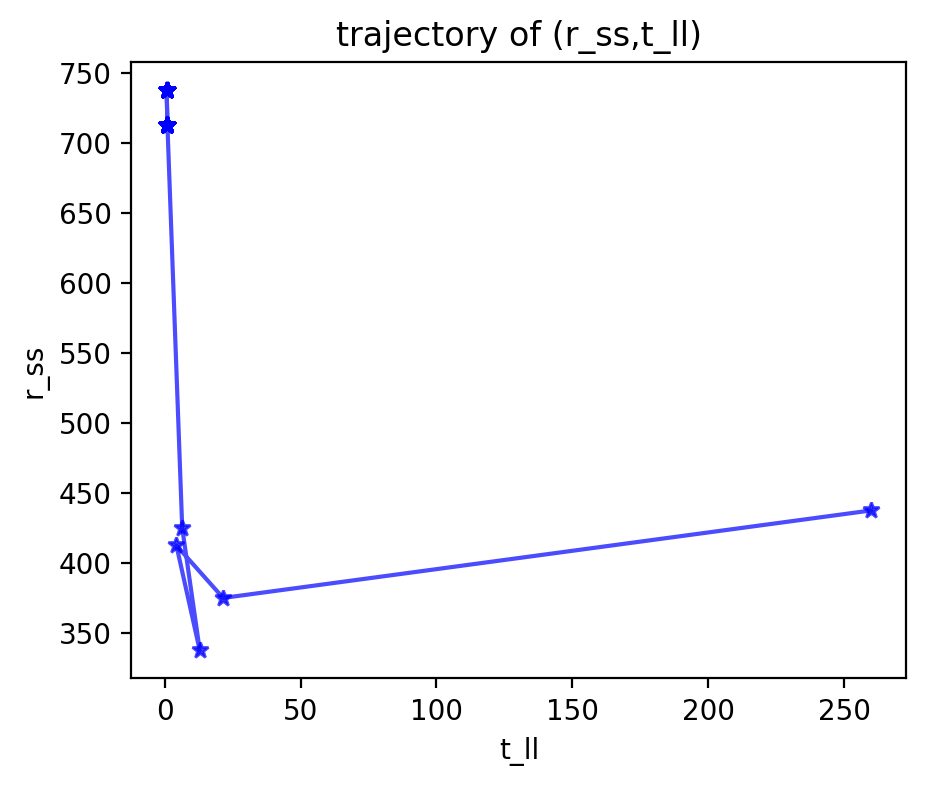

In [105]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 1, figsize = [5, 4])

# Draw black dotted lines for true parameters

df_cond = df_simul
line_color = 'blue'
ax = df_cond.plot(x='t_ll', y='r_ss', ax=ax,style='*-',
                    subplots=True, legend=False, color = line_color, alpha = 0.7)
ax[0].set_ylabel('r_ss')
# Set titles and limits on y axes.
ax[0].set_title('trajectory of (r_ss,t_ll)')

plt.show()

### Results

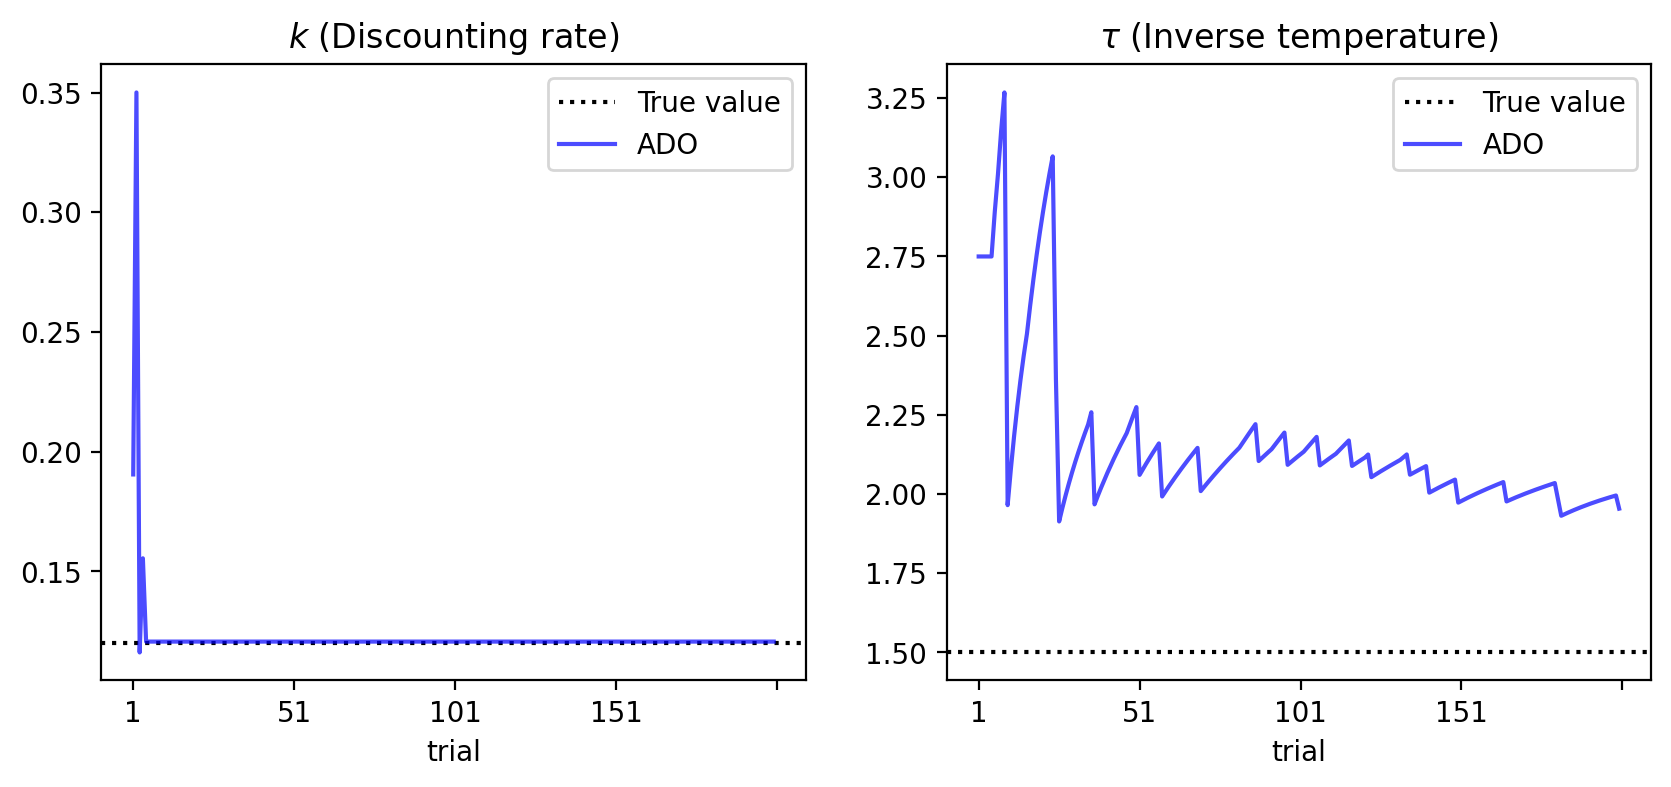

In [97]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1, 2, figsize = [10, 4])

# Draw black dotted lines for true parameters
for i, param in enumerate(['k', 'tau']):
    ax[i].axhline(PARAM_TRUE[param], color='black', linestyle=':')

df_cond = df_simul
line_color = 'blue'
ax = df_cond.plot(x='trial', y=['mean_k', 'mean_tau'], ax=ax,
                    subplots=True, legend=False, color = line_color, alpha = 0.7)

# Set titles and limits on y axes.
ax[0].set_title('$k$ (Discounting rate)')
ax[1].set_title('$\\tau$ (Inverse temperature)')

ax[0].legend(['True value', 'ADO'])
ax[1].legend(['True value', 'ADO'])
    
plt.show()

## References

Green, L. & Myerson, J. (2004). A discounting framework for choice with delayed and probabilistic rewards. Psychological Bulletin, 130, 769–792.

Mazur, J. E. (1987). An adjusting procedure for studying delayed reinforcement. Commons, ML.; Mazur, JE.; Nevin, JA, 55–73.
